In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('data_progress/4 PZZ.xlsx')
df.geocodes = df.geocodes.apply(eval) #xlsx requires, pkl doesn't, but it weighs a lot

In [3]:
df.head()

,fio,comment,resolution,part,page,exact_page,orig_id,list_flag,fio_n,fio_n_popularity,...,comment_list_popularity,multiplier,comment_class_manual,resolution_class_manual,comment_class_prediction,resolution_class_prediction,comment_class,resolution_class,geocodes,geocodes_number
0,Захаренко В. А.,Во все разделы правил землепользования и застр...,"Предложения, относящиеся к предмету публичных ...",1,1,True,0,False,Захаренко В. А.,2.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'city': 'Москва', 'house': None, 'street': '...",1
1,Калантарова Ю. В.,На основании вступившего в законную силу судеб...,"Предложения, относящиеся к предмету публичных ...",1,1,True,1,False,Калантарова Ю. В.,3.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'city': 'Москва', 'house': None, 'street': '...",1
2,Ткач Е. В.,"В картах ПЗЗ не отражены ""Защитные зоны ОКН"" (...",Замечание рекомендовано к учёту. Рекомендовать...,1,5,True,2,False,Ткач Е. В.,4.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,[],0
3,Крупенина О. Н.,"На карте Градостроительного зонирования ""Грани...",1. Предложение предусмотрено проектом ПЗЗ. На ...,1,6,True,3,False,Крупенина О. Н.,1.0,...,1,1,1.0,-1.0,-1,-1,1,-1,[],0
4,Терехов А. С.,Внести в Проект правил землепользования и заст...,Предложение не рекомендовано к учёту. Отсутств...,1,6,True,4,False,Терехов А. С.,2.0,...,1,1,-1.0,-1.0,-1,-1,-1,-1,"[{'city': 'Москва', 'house': None, 'street': '...",1


# Удалим повторы
*(ранее не были удалены, чтобы осталась возможность проанализировать дубли, но здесь это не нужно)*

In [4]:
len(df)

114011

In [5]:
df.drop_duplicates(subset=['fio_n', 'comment', 'resolution'], inplace=True)
df.index = range(len(df))

In [6]:
len(df)

112346

# Разобъём записи с N геометок на N отдельных записей

In [7]:
t = df[df.geocodes_number>0]

In [8]:
tv = []
geocode_column = np.argmax(t.columns == 'geocodes')
for row in t.values:
    for geo in row[geocode_column]:
        tv.append(list(row) + [geo])

In [9]:
df.geocodes[0]

[{'city': 'Москва',
  'coordinates': [37.612416, 55.777454],
  'house': None,
  'name': '1-й Самотёчный переулок',
  'street': '1-й Самотёчный переулок'}]

In [10]:
ddf = pd.DataFrame(tv, columns=(list(t.columns)+['geo']))
for f in ['city','street','house','coordinates']:
    ddf[f] = ddf.geo.apply(lambda x: x[f])
ddf['address_name'] = ddf.geo.apply(lambda x: x['name'])
ddf = ddf.drop('geo', axis=1)

Было всего комментариев

In [11]:
len(df)

112346

Комментариев хоть с одной геометкой

In [12]:
len(t)

36545

Отдельных пар коммент-геометка

In [13]:
len(ddf)

68283

*итак, у нас есть куча записей с повторяющимися координатами. Если геосервис сам умеет группировать записи по одинаковым координатам, то можно тогда здесь остановиться и сохранить текущий результат. Но если же нет, то тогда надо сделать эту группировку руками*

*я воспользовался [офигенно удобным сервисом от Google](https://support.google.com/mymaps/answer/3024836?hl=ru&ref_topic=3024924&authuser=0), который позволяет просто закинуть файл и тут же получить результат, а также даёт возможность редактировать всякие расцветки маркеров + поиск по данным карты + просмотр очень больших описаний меток (но не бесконечных) + отрисовка фигур*

------

# Группируем кучу геометок по их координате и типу комментария (за/против), объединяя описания

отсортируем в некотором порядке, который обеспечит нахождение каждой нужной группы записей в одном месте, а также нахождение комментариев с большим количеством подписей в начале

In [14]:
ddf = ddf.sort_values(by=['address_name', 'comment_class', 'comment_popularity', 'comment', 'page'], ascending=[True, True, False, True, True])
ddf.index = range(len(ddf))

А далее идёт составная история:
* 1 комментарий может содержать нескольких заявителей (при точном повторе комментария и резолюции)
* 1 геометка может содержать несколько комментариев

создадим для них классы и пусть каждый умеет генерировать за себя описание

In [15]:
class Comment:
    def __init__(self, record):
        self.comment = record.comment
        self.resolution = record.resolution
        self.resolution_class = record.resolution_class
        self.fios_and_pages = [(record.fio, record.page)]
        self.multipliers = [record.multiplier]
        self.record = record

    @property
    def votes_num(self):
        return sum(self.multipliers)
    
    @property
    def pages(self):
        return set([fp[1] for fp in self.fios_and_pages])
    
    @property
    def fios_num(self):
        return len(self.fios_and_pages)
    
    def _get_fios_by_page(self, p):
        return [fp[0] for fp in self.fios_and_pages if fp[1]==p]
    
    def fits(self, record):
        return self.comment == record.comment and self.resolution == record.resolution
    
    def append(self, record):
        self.fios_and_pages.append((record.fio, record.page))
        self.multipliers.append(record.multiplier)

    def get_descr(self, text_lim = None):
        fios_and_pages = []
        pages = sorted(self.pages, key = lambda p: len(self._get_fios_by_page(p))-p/20000, reverse=True)
        for p in pages:
            fios = self._get_fios_by_page(p)
            if len(fios)==1:
                fios_and_pages.append("{} (стр. {})".format(fios[0], p))
            elif len(fios)<=4:
                fios_and_pages.append("стр. {}: {}".format(p, ", ".join(fios)))
            else:
                fios_and_pages.append("стр. {}: {} и ещё {} чел.".format(p, fios[0], len(fios)-1))
        fios_and_pages = "; ".join(fios_and_pages)
        comment = self.comment if not text_lim or len(str(self.comment))<text_lim-3 else self.comment[:(text_lim-3)]+'...'
        resolution = self.resolution if not text_lim or len(str(self.resolution))<text_lim-3 else self.resolution[:(text_lim-3)]+'...'
        comment_and_resolution = '>Житель: {}\n\n> Москва: {}'.format(comment, resolution)
        return '{}\n\n{}'.format(fios_and_pages, comment_and_resolution)

In [16]:
class GeoMark:
    def __init__(self, record):
        self.coordinates = record.coordinates
        self.comment_class = record.comment_class
        self.address_name = record.address_name
        self.comments = [Comment(record)]
    
    def fits(self, record):
        return self.coordinates == record.coordinates and self.comment_class == record.comment_class
    
    def append(self, record):
        if self.comments[-1].fits(record):
            self.comments[-1].append(record)
        else:
            self.comments.append(Comment(record))
    
    def get_descr(self):
        delim = '\n\n=======\n\n'
        page_nums = sorted(list(set(sum([[fp[1] for fp in c.fios_and_pages] for c in self.comments], []))))
        pages = ', '.join([str(p) for p in page_nums])
        votes = sum([sum(c.multipliers) for c in self.comments])
        resp = '{}\nГолосов: {}\nУникальных комментариев: {}\nНомера страниц: {}'.format(self.address_name, votes, len(self.comments), pages) + delim
        comments_sorted = sorted(self.comments, key=lambda c: c.votes_num, reverse=True)
        text_lim = None
        if len(comments_sorted)>10:
            text_lim = 150
        elif len(comments_sorted)>3:
            text_lim = 400
        elif len(comments_sorted)>1:
            text_lim = 800
        return resp + delim.join([comment.get_descr(text_lim) for comment in comments_sorted])
    
    def get_data(self):
        return [self.coordinates,
                self.comment_class,
                self.get_descr(),
                sum([c.votes_num for c in self.comments]),
                self.comments]

Пилим геометки

In [17]:
geo_marks = []
for row in ddf.iterrows():
    record = row[1]
    if geo_marks and geo_marks[-1].fits(record):
        geo_marks[-1].append(record)
    else:
        geo_marks.append(GeoMark(record))

Посмотрим описание пары геометок, у которых не самые простые случаи:

In [18]:
tm = [g for g in geo_marks if max([max(c.multipliers) for c in g.comments])>1]
print(tm[1].get_descr())

1-й Земельный переулок
Голосов: 3551
Уникальных комментариев: 112
Номера страниц: 10, 25, 135, 184, 266, 489, 771, 773, 774, 776, 778, 914, 1109, 1134, 1137, 1148, 1547, 1893, 1894, 1896, 1897, 1962, 1971, 2099, 2167, 2168, 2421, 2567, 2765, 2787, 3022, 3035, 3074, 3077, 3127, 3407, 3470, 3511, 3512, 3513, 3514, 3515, 3516, 3517, 3518, 3519, 3520, 3521, 3531, 4114, 4183, 4312, 4366, 4419, 4504, 4505, 4509, 4514, 4516, 4520, 4662, 4682, 4684, 4687, 4689, 4694, 4699, 4709, 4837, 4840, 4842, 5353, 5354, 5750, 6111, 6115, 6118, 6120, 6124, 6125, 6546, 6605, 6622, 7019, 7020, 7021, 7022, 7023, 7054, 7060, 7646, 7721, 7882, 7890, 8008, 8012, 8022, 8073, 8107, 8123, 8917, 10285, 10290, 10292, 10296


Брюханова Анастасия Андреевна (12-05- 13793/6) Смирнов Анатолий Анатольевич, проспект Маршала Жукова, д. 41 ТОС "Велтон" (+1500 подписей) (стр. 8917)

>Житель: В соответствии со ст. 68 Градостроительного кодекса г, Москвы прошу внести в Протокол публичных слушаний по «Проекту Правил землепользова

In [19]:
tc = [g for g in geo_marks if len(g.comments[0].fios_and_pages)>1 and len(g.comments)==2]
print(tc[1].get_descr())

1-я Курьяновская улица
Голосов: 33
Уникальных комментариев: 2
Номера страниц: 900, 4925


стр. 4925: Лукьяшко Геннадий Иванович и ещё 31 чел.

>Житель: были размещены объявления о проведении публичных слушаний, газету с извещением о проведении публичных слушаний в почтовые ящики нам не доставляли, что является нарушением п.7ст.68 Градостроительного Кодекса г. Москвы со стороны соответствующих должностных лиц Управы и Префектуры района Печатники г. Москвы. Не все жители Москвы являются пользователями Интернета (в силу возраста, отсутствия навыков или доступа к Интернету), а законодательство РФ и Москвы не возлагает на жителей города обязанности владения навыками пользования Интернетом.
1.2. Жителей желающих принять участие в слушаниях не пускали в зал, к котором проходили слушания. 22.12.2016г. при регистрации на публичных слушаниях сотрудникам госорганизаций, общественным советникам, представителям общественных организаций, привезенных...

> Москва: разрешенного использования земельных

А вот что мы получаем в итоге:

In [20]:
gdf = pd.DataFrame([g.get_data() for g in geo_marks], columns=['coordinates', 'comments_class', 'description', 'votes_number', 'comments'])

In [21]:
gdf.head(5)

,coordinates,comments_class,description,votes_number,comments
0,"[37.656622, 55.704915]",1,1-й Автозаводский проезд\nГолосов: 1\nУникальн...,1,[<__main__.Comment object at 0x1164b0048>]
1,"[37.65699, 55.705219]",-1,"1-й Автозаводский проезд, 3\nГолосов: 1\nУника...",1,[<__main__.Comment object at 0x1164b0198>]
2,"[37.663701, 55.770892]",1,"1-й Басманный переулок, 6\nГолосов: 29\nУникал...",29,[<__main__.Comment object at 0x1164b0278>]
3,"[37.634263, 55.849706]",-1,1-й Ботанический проезд\nГолосов: 4\nУникальны...,4,"[<__main__.Comment object at 0x1164b0160>, <__..."
4,"[37.650711, 55.741262]",-1,1-й Гончарный переулок\nГолосов: 2\nУникальных...,2,"[<__main__.Comment object at 0x1164b0438>, <__..."


In [22]:
gdf.comments_class.value_counts()

-1    1749
 1    1194
Name: comments_class, dtype: int64

Сохраняем результат. **Google не разрешает больше 2000 меток в одном слое**

In [23]:
geo_m = gdf[gdf.comments_class==-1][['coordinates', 'description']]
geo_p = gdf[gdf.comments_class==1][['coordinates', 'description']]
geo_m.to_csv('data_progress/geo/4 geo_m.csv', index=False)
geo_p.to_csv('data_progress/geo/4 geo_p.csv', index=False)

Добавим отдельным слоем места, в которых больше 50 голосов

In [24]:
pop = 50
pop_p = gdf[(gdf.votes_number>pop)&(gdf.comments_class==1)][['coordinates', 'description']]
pop_m = gdf[(gdf.votes_number>pop)&(gdf.comments_class==-1)][['coordinates', 'description']]
pop_p.to_csv('data_progress/geo/4 geo_popular_p.csv', index=False)
pop_m.to_csv('data_progress/geo/4 geo_popular_m.csv', index=False)
print('Геометок За с более {} голосов: {}'.format(pop, len(pop_p)))
print('Геометок Против с более {} голосов: {}'.format(pop, len(pop_m)))

Геометок За с более 50 голосов: 27
Геометок Против с более 50 голосов: 187


Вот такая карта получится

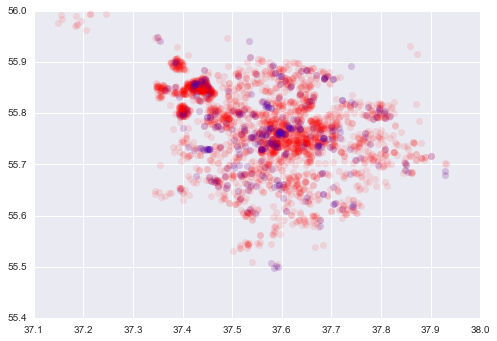

In [25]:
plt.plot([c[0] for c in gdf.coordinates], [c[1] for c in gdf.coordinates], 'ro', alpha=0.1)
plt.plot([c[0] for c in gdf[gdf.votes_number>20].coordinates], [c[1] for c in gdf[gdf.votes_number>20].coordinates], 'ro', alpha=0.1, color='blue')

Сохраним для последующего возможного анализа поблочно (heatmap)

In [26]:
gdf.to_pickle('data_progress/geo/5 GeoMarks.pkl')

In [27]:
gdf.drop('comments', axis=1).to_excel('data_progress/geo/5 GeoMarks.xlsx')

------